# Data Reading

In [1]:
import pandas as pd

account_filename = 'data/accountData.csv'
customer_filename = 'data/customerData.csv'
transaction_filename = 'data/transactionData.csv'
labels_filename = 'data/labelledData_15.csv'

In [2]:
accounts = pd.read_csv(account_filename)

In [3]:
customers = pd.read_csv(customer_filename)

In [4]:
transactions = pd.read_csv(transaction_filename)

In [5]:
labels = pd.read_csv(labels_filename)

# Data Preprocessing

In [6]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

Using TensorFlow backend.


In [ ]:
transactions.describe()

In [ ]:
print(sum(labels['Class'])/float(len(labels)))

In [ ]:
print(len(transactions))
n = float(len(transactions))
print((len(transactions) - len(transactions['ORIGIN_CUSTOMER_ID'].dropna()))/n)
print((len(transactions) - len(transactions['ORIGIN_ACCOUNT_ID'].dropna()))/n)
print((len(transactions) - len(transactions['BENEFICIARY_CUSTOMER_ID'].dropna()))/n)
print((len(transactions) - len(transactions['BENEFICIARY_ACCOUNT_ID'].dropna()))/n)

In [7]:
del transactions['TRANSACTION_ID']
del transactions['BENEFICIARY_CUSTOMER_ID'] 
del transactions['BENEFICIARY_ACCOUNT_ID']

In [8]:
transactions['ORIGIN_CUSTOMER_ID'].fillna(2.5e+05, inplace=True)
transactions['ORIGIN_ACCOUNT_ID'].fillna(5.317910e+05, inplace=True)

In [9]:
transactions['TRANSACTION_SOURCE'] = transactions['TRANSACTION_SOURCE'].astype('category').cat.codes
transactions['TRANSACTION_TYPE'] = transactions['TRANSACTION_TYPE'].astype('category').cat.codes

In [10]:
transactions = transactions.merge(customers, left_on='ORIGIN_CUSTOMER_ID', right_on='CUSTOMER_ID', how='left')

In [11]:
transactions['CUSTOMER_RISK_SCORE'].fillna(transactions['CUSTOMER_RISK_SCORE'].mean(), inplace=True)

In [12]:
transactions['CUSTOMER_TYPE'].fillna('unknown', inplace=True)
transactions['COUNTRY'].fillna('unknown', inplace=True)

In [13]:
transactions['CUSTOMER_TYPE'] = transactions['CUSTOMER_TYPE'].astype('category').cat.codes
transactions['COUNTRY'] = transactions['COUNTRY'].astype('category').cat.codes

In [14]:
transactions['TRANSACTION_DATE_TIME'] = pd.to_datetime(transactions['TRANSACTION_DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

In [15]:
transactions['Day'] = transactions['TRANSACTION_DATE_TIME'].dt.strftime('%d').astype('float64')
transactions['Hour'] = transactions['TRANSACTION_DATE_TIME'].dt.strftime('%H').astype('float64')
transactions['Minute'] = transactions['TRANSACTION_DATE_TIME'].dt.strftime('%M').astype('float64')

In [16]:
del transactions['TRANSACTION_DATE_TIME']

In [30]:
len(transactions.columns)

11

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
transactions[['TRANSACTION_AMOUNT']] = scaler.fit_transform(transactions[['TRANSACTION_AMOUNT']])
transactions[['TRANSACTION_TYPE']] = scaler.fit_transform(transactions[['TRANSACTION_TYPE']])
transactions[['TRANSACTION_SOURCE']] = scaler.fit_transform(transactions[['TRANSACTION_SOURCE']])
transactions[['ORIGIN_CUSTOMER_ID']] = scaler.fit_transform(transactions[['ORIGIN_CUSTOMER_ID']])
transactions[['ORIGIN_ACCOUNT_ID']] = scaler.fit_transform(transactions[['ORIGIN_ACCOUNT_ID']])
transactions[['CUSTOMER_RISK_SCORE']] = scaler.fit_transform(transactions[['CUSTOMER_RISK_SCORE']])
transactions[['CUSTOMER_TYPE']] = scaler.fit_transform(transactions[['CUSTOMER_TYPE']])
transactions[['COUNTRY']] = scaler.fit_transform(transactions[['COUNTRY']])


transactions[['Day']] = scaler.fit_transform(transactions[['Day']])
transactions[['Hour']] = scaler.fit_transform(transactions[['Hour']])
transactions[['Minute']] = scaler.fit_transform(transactions[['Minute']])

In [28]:
del transactions['CUSTOMER_ID']

In [19]:
transactions.to_csv('data/transactionData_clean.csv')

In [29]:
transactions.describe()

,ORIGIN_CUSTOMER_ID,ORIGIN_ACCOUNT_ID,TRANSACTION_TYPE,TRANSACTION_SOURCE,TRANSACTION_AMOUNT,CUSTOMER_TYPE,COUNTRY,CUSTOMER_RISK_SCORE,Day,Hour,Minute
count,1.577224e+07,1.577224e+07,1.577224e+07,1.577224e+07,1.577224e+07,1.577224e+07,1.577224e+07,1.577224e+07,1.577224e+07,1.577224e+07,1.577224e+07
mean,5.187897e-01,5.186080e-01,6.290893e-01,3.453548e-01,5.231189e-04,4.707365e-01,9.115290e-01,2.370823e-01,5.000263e-01,4.999186e-01,5.001508e-01
std,2.986303e-01,2.986206e-01,3.559929e-01,2.381447e-01,3.667259e-03,1.794756e-01,1.276145e-01,1.262523e-01,2.981771e-01,3.010166e-01,2.935314e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.606480e-01,2.599762e-01,4.000000e-01,2.857143e-01,1.901000e-06,5.000000e-01,9.360000e-01,1.395349e-01,2.333333e-01,2.173913e-01,2.542373e-01
50%,5.190720e-01,5.190611e-01,6.000000e-01,2.857143e-01,5.479001e-06,5.000000e-01,9.360000e-01,2.209302e-01,5.000000e-01,4.782609e-01,5.084746e-01
75%,7.794880e-01,7.793099e-01,1.000000e+00,4.285714e-01,6.926101e-05,5.000000e-01,9.360000e-01,3.023256e-01,7.666667e-01,7.391304e-01,7.627119e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [26]:
print(sum(pd.isnull(transactions['TRANSACTION_TYPE'])))

0


# Autoencoder

In [46]:
input_layer = Input(shape=(11, ))
encoder = Dense(10, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(8, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(6, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(4, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(encoder)
#encoder = Dense(7, activation="tanh", 
#                activity_regularizer=regularizers.l1(10e-5))(encoder)
#encoder = Dense(6, activation="tanh", 
#                activity_regularizer=regularizers.l1(10e-5))(encoder)
#encoder = Dense(3, activation="tanh", 
#                activity_regularizer=regularizers.l1(10e-5))(encoder)
encoder = Dense(2, activation="relu")(encoder)

decoder = Dense(4, activation='tanh')(encoder)
decoder = Dense(6, activation='tanh')(decoder)
decoder = Dense(8, activation='tanh')(decoder)
decoder = Dense(10, activation='tanh')(decoder)
decoder = Dense(11, activation='tanh')(decoder)
#decoder = Dense(8, activation='tanh')(decoder)
#decoder = Dense(9, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [47]:
from keras import optimizers
adam = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

autoencoder.compile(optimizer=adam, loss='mean_squared_error')

In [33]:
X_train = transactions.values

In [34]:
# run on gpu0
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
nb_epoch = 1
batch_size = 16
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 12617788 samples, validate on 3154447 samples
Epoch 1/1
 8555344/12617788 [===================>..........] - ETA: 189s - loss: 0.0275   

# Prediction and Confusion Matrix

In [36]:
predictions = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': labels['Class']})
error_df.describe()

,reconstruction_error,true_class
count,1.577224e+07,1.577224e+07
mean,3.159930e-02,4.000067e-04
std,1.769662e-02,1.999617e-02
min,2.465920e-04,0.000000e+00
25%,1.882534e-02,0.000000e+00
50%,2.898212e-02,0.000000e+00
75%,4.120287e-02,0.000000e+00
max,1.945786e-01,1.000000e+00


In [37]:
threshold = 0.075

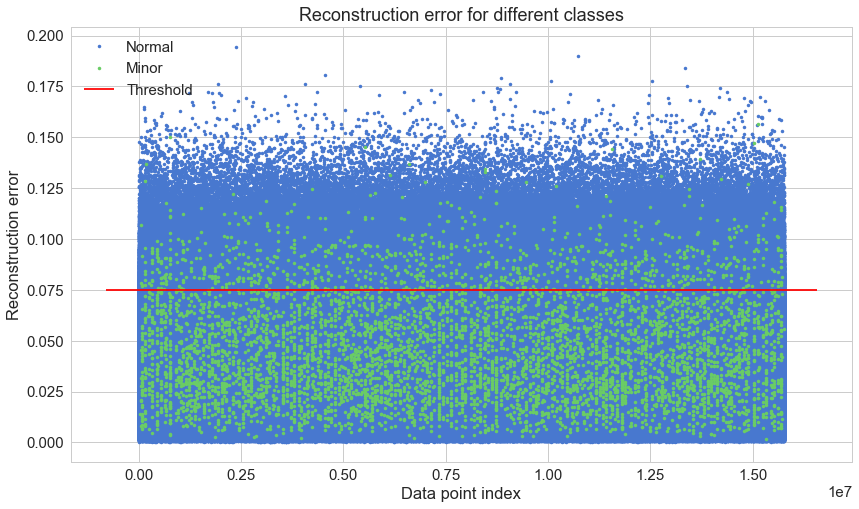

In [38]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Minor" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

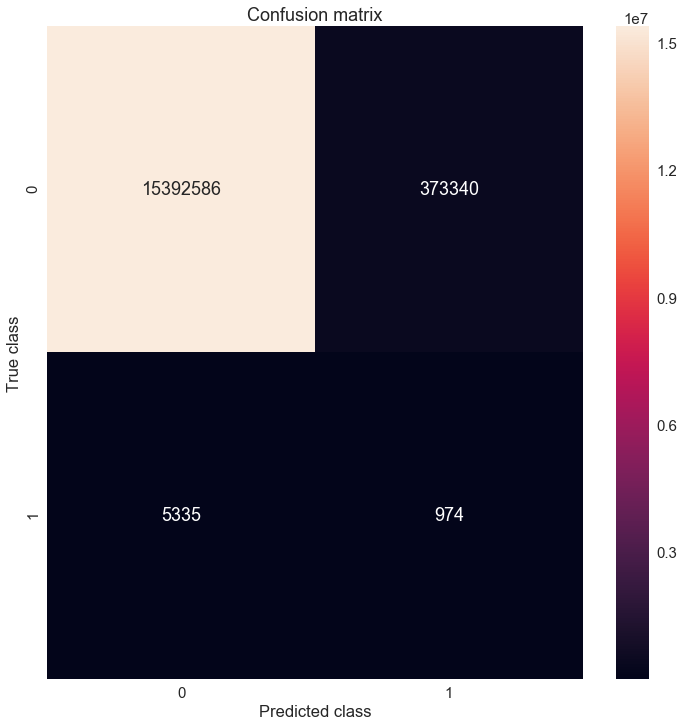

In [39]:
from sklearn.metrics import confusion_matrix
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=[0, 1], yticklabels=[0, 1], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()